# Loop 23 Analysis: Per-N Efficiency and Improvement Potential

After 24 experiments, all approaches converge to ~70.627. The evaluator recommends:
1. Analyze per-N efficiency to find worst performers
2. Target specific N values with highest improvement potential
3. Manual inspection of worst N values

In [1]:
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.affinity import rotate, translate
import matplotlib.pyplot as plt

TREE_TEMPLATE = [
    (0.0, 0.8), (0.125, 0.5), (0.0625, 0.5), (0.2, 0.25), (0.1, 0.25),
    (0.35, 0.0), (0.075, 0.0), (0.075, -0.2), (-0.075, -0.2), (-0.075, 0.0),
    (-0.35, 0.0), (-0.1, 0.25), (-0.2, 0.25), (-0.0625, 0.5), (-0.125, 0.5)
]

def parse_s_value(val):
    if isinstance(val, str) and val.startswith('s'):
        return float(val[1:])
    return float(val)

def create_tree_polygon(x, y, angle):
    tree = Polygon(TREE_TEMPLATE)
    tree = rotate(tree, angle, origin=(0, 0), use_radians=False)
    tree = translate(tree, x, y)
    return tree

def get_bounding_box_side(trees):
    all_x, all_y = [], []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    return max(max(all_x) - min(all_x), max(all_y) - min(all_y))

# Load baseline
df = pd.read_csv('/home/submission/submission.csv')
df['x'] = df['x'].apply(parse_s_value)
df['y'] = df['y'].apply(parse_s_value)
df['deg'] = df['deg'].apply(parse_s_value)
df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))

print(f"Loaded {len(df)} rows")
print(f"N range: {df['n'].min()} to {df['n'].max()}")
print(f"Total trees: {df.groupby('n').size().sum()}")
print(f"Expected: {sum(range(1, 201))} = {200*201//2}")
print()

Loaded 20100 rows
N range: 1 to 200
Total trees: 20100
Expected: 20100 = 20100



In [2]:
# Calculate per-N scores and efficiency
results = []

for n in range(1, 201):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    side = get_bounding_box_side(trees)
    score = (side ** 2) / n
    
    # Calculate theoretical minimum (single tree area * n / n = single tree area)
    # But for packing, the theoretical minimum is harder to compute
    # Let's use the tree's bounding box as a reference
    single_tree = create_tree_polygon(0, 0, 0)
    tree_width = single_tree.bounds[2] - single_tree.bounds[0]  # 0.7
    tree_height = single_tree.bounds[3] - single_tree.bounds[1]  # 1.0
    tree_area = single_tree.area
    
    # Theoretical minimum: if we could pack perfectly, area = n * tree_area
    # So side = sqrt(n * tree_area), score = n * tree_area / n = tree_area
    # But trees can't overlap, so this is a lower bound
    theoretical_min_area = n * tree_area
    theoretical_min_side = np.sqrt(theoretical_min_area)
    theoretical_min_score = tree_area  # ~0.3325 for this tree
    
    # Efficiency: how close to theoretical minimum
    efficiency = theoretical_min_score / score  # Higher is better
    
    results.append({
        'n': n,
        'side': side,
        'score': score,
        'theoretical_min': theoretical_min_score,
        'efficiency': efficiency,
        'gap': score - theoretical_min_score
    })

results_df = pd.DataFrame(results)
print(f"Tree area: {tree_area:.6f}")
print(f"Tree dimensions: {tree_width:.3f} x {tree_height:.3f}")
print()
print("Per-N Score Statistics:")
print(results_df[['n', 'score', 'efficiency', 'gap']].describe())

Tree area: 0.245625
Tree dimensions: 0.700 x 1.000

Per-N Score Statistics:
                n       score  efficiency         gap
count  200.000000  200.000000  200.000000  200.000000
mean   100.500000    0.353138    0.698565    0.107513
std     57.879185    0.028099    0.039555    0.028099
min      1.000000    0.329945    0.371456    0.084320
25%     50.750000    0.340034    0.680806    0.094409
50%    100.500000    0.346921    0.708015    0.101296
75%    150.250000    0.360786    0.722355    0.115161
max    200.000000    0.661250    0.744443    0.415625


In [3]:
# Find worst performers (lowest efficiency)
print("\n" + "="*70)
print("WORST PERFORMERS (lowest efficiency - highest improvement potential)")
print("="*70)
worst = results_df.nsmallest(20, 'efficiency')
for _, row in worst.iterrows():
    print(f"N={row['n']:3.0f}: score={row['score']:.6f}, efficiency={row['efficiency']:.4f}, gap={row['gap']:.6f}")

print("\n" + "="*70)
print("BEST PERFORMERS (highest efficiency)")
print("="*70)
best = results_df.nlargest(20, 'efficiency')
for _, row in best.iterrows():
    print(f"N={row['n']:3.0f}: score={row['score']:.6f}, efficiency={row['efficiency']:.4f}, gap={row['gap']:.6f}")


WORST PERFORMERS (lowest efficiency - highest improvement potential)
N=  1: score=0.661250, efficiency=0.3715, gap=0.415625
N=  2: score=0.450779, efficiency=0.5449, gap=0.205154
N=  3: score=0.434745, efficiency=0.5650, gap=0.189120
N=  5: score=0.416850, efficiency=0.5892, gap=0.171225
N=  4: score=0.416545, efficiency=0.5897, gap=0.170920
N=  7: score=0.399897, efficiency=0.6142, gap=0.154272
N=  6: score=0.399610, efficiency=0.6147, gap=0.153985
N=  9: score=0.387415, efficiency=0.6340, gap=0.141790
N=  8: score=0.385407, efficiency=0.6373, gap=0.139782
N= 15: score=0.376978, efficiency=0.6516, gap=0.131353
N= 10: score=0.376630, efficiency=0.6522, gap=0.131005
N= 21: score=0.376451, efficiency=0.6525, gap=0.130826
N= 20: score=0.376057, efficiency=0.6532, gap=0.130432
N= 22: score=0.375258, efficiency=0.6545, gap=0.129633
N= 11: score=0.374924, efficiency=0.6551, gap=0.129299
N= 16: score=0.374128, efficiency=0.6565, gap=0.128503
N= 26: score=0.373997, efficiency=0.6568, gap=0.12

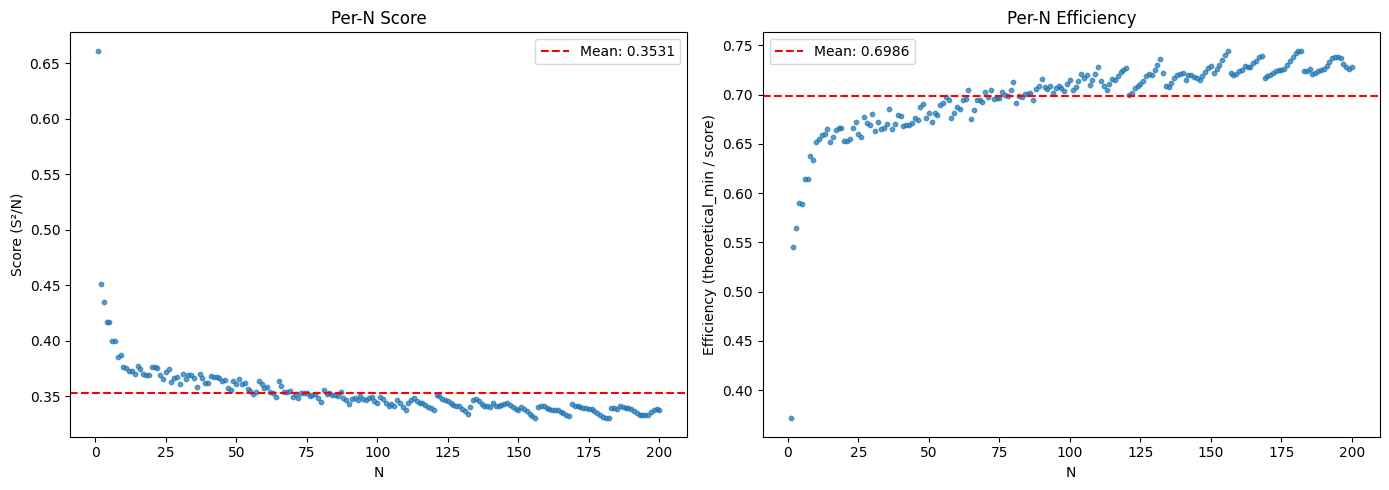


Total score: 70.627582
Target: 68.919154
Gap: 1.708428


In [4]:
# Plot efficiency vs N
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.scatter(results_df['n'], results_df['score'], s=10, alpha=0.7)
plt.xlabel('N')
plt.ylabel('Score (S²/N)')
plt.title('Per-N Score')
plt.axhline(y=results_df['score'].mean(), color='r', linestyle='--', label=f'Mean: {results_df["score"].mean():.4f}')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(results_df['n'], results_df['efficiency'], s=10, alpha=0.7)
plt.xlabel('N')
plt.ylabel('Efficiency (theoretical_min / score)')
plt.title('Per-N Efficiency')
plt.axhline(y=results_df['efficiency'].mean(), color='r', linestyle='--', label=f'Mean: {results_df["efficiency"].mean():.4f}')
plt.legend()

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=150)
plt.show()

print(f"\nTotal score: {results_df['score'].sum():.6f}")
print(f"Target: 68.919154")
print(f"Gap: {results_df['score'].sum() - 68.919154:.6f}")

In [5]:
# Analyze score contribution by N range
ranges = [
    (1, 10, 'N=1-10'),
    (11, 20, 'N=11-20'),
    (21, 50, 'N=21-50'),
    (51, 100, 'N=51-100'),
    (101, 150, 'N=101-150'),
    (151, 200, 'N=151-200')
]

print("\nScore contribution by N range:")
print("="*60)
for start, end, label in ranges:
    mask = (results_df['n'] >= start) & (results_df['n'] <= end)
    range_score = results_df.loc[mask, 'score'].sum()
    range_count = mask.sum()
    avg_efficiency = results_df.loc[mask, 'efficiency'].mean()
    print(f"{label:15s}: score={range_score:8.4f} ({range_count:3d} N values), avg_efficiency={avg_efficiency:.4f}")

print(f"\nTotal: {results_df['score'].sum():.6f}")


Score contribution by N range:
N=1-10         : score=  4.3291 ( 10 N values), avg_efficiency=0.5813
N=11-20        : score=  3.7241 ( 10 N values), avg_efficiency=0.6596
N=21-50        : score= 10.9807 ( 30 N values), avg_efficiency=0.6712
N=51-100       : score= 17.6143 ( 50 N values), avg_efficiency=0.6974
N=101-150      : score= 17.1364 ( 50 N values), avg_efficiency=0.7168
N=151-200      : score= 16.8430 ( 50 N values), avg_efficiency=0.7292

Total: 70.627582


In [6]:
# Look at specific N values that might have symmetric optimal solutions
# From discussions: perfect squares, triangular numbers, etc.

print("\nAnalysis of special N values:")
print("="*60)

# Perfect squares
print("\nPerfect squares (N = k²):")
for k in range(1, 15):
    n = k * k
    if n <= 200:
        row = results_df[results_df['n'] == n].iloc[0]
        print(f"  N={n:3d} (k={k}): score={row['score']:.6f}, efficiency={row['efficiency']:.4f}")

# Triangular numbers
print("\nTriangular numbers (N = k(k+1)/2):")
for k in range(1, 20):
    n = k * (k + 1) // 2
    if n <= 200:
        row = results_df[results_df['n'] == n].iloc[0]
        print(f"  N={n:3d} (k={k}): score={row['score']:.6f}, efficiency={row['efficiency']:.4f}")


Analysis of special N values:

Perfect squares (N = k²):
  N=  1 (k=1): score=0.661250, efficiency=0.3715
  N=  4 (k=2): score=0.416545, efficiency=0.5897
  N=  9 (k=3): score=0.387415, efficiency=0.6340
  N= 16 (k=4): score=0.374128, efficiency=0.6565
  N= 25 (k=5): score=0.372144, efficiency=0.6600
  N= 36 (k=6): score=0.358391, efficiency=0.6854
  N= 49 (k=7): score=0.363430, efficiency=0.6759
  N= 64 (k=8): score=0.348773, efficiency=0.7043
  N= 81 (k=9): score=0.355207, efficiency=0.6915
  N=100 (k=10): score=0.343427, efficiency=0.7152
  N=121 (k=11): score=0.351324, efficiency=0.6991
  N=144 (k=12): score=0.342276, efficiency=0.7176
  N=169 (k=13): score=0.342500, efficiency=0.7172
  N=196 (k=14): score=0.333262, efficiency=0.7370

Triangular numbers (N = k(k+1)/2):
  N=  1 (k=1): score=0.661250, efficiency=0.3715
  N=  3 (k=2): score=0.434745, efficiency=0.5650
  N=  6 (k=3): score=0.399610, efficiency=0.6147
  N= 10 (k=4): score=0.376630, efficiency=0.6522
  N= 15 (k=5): scor

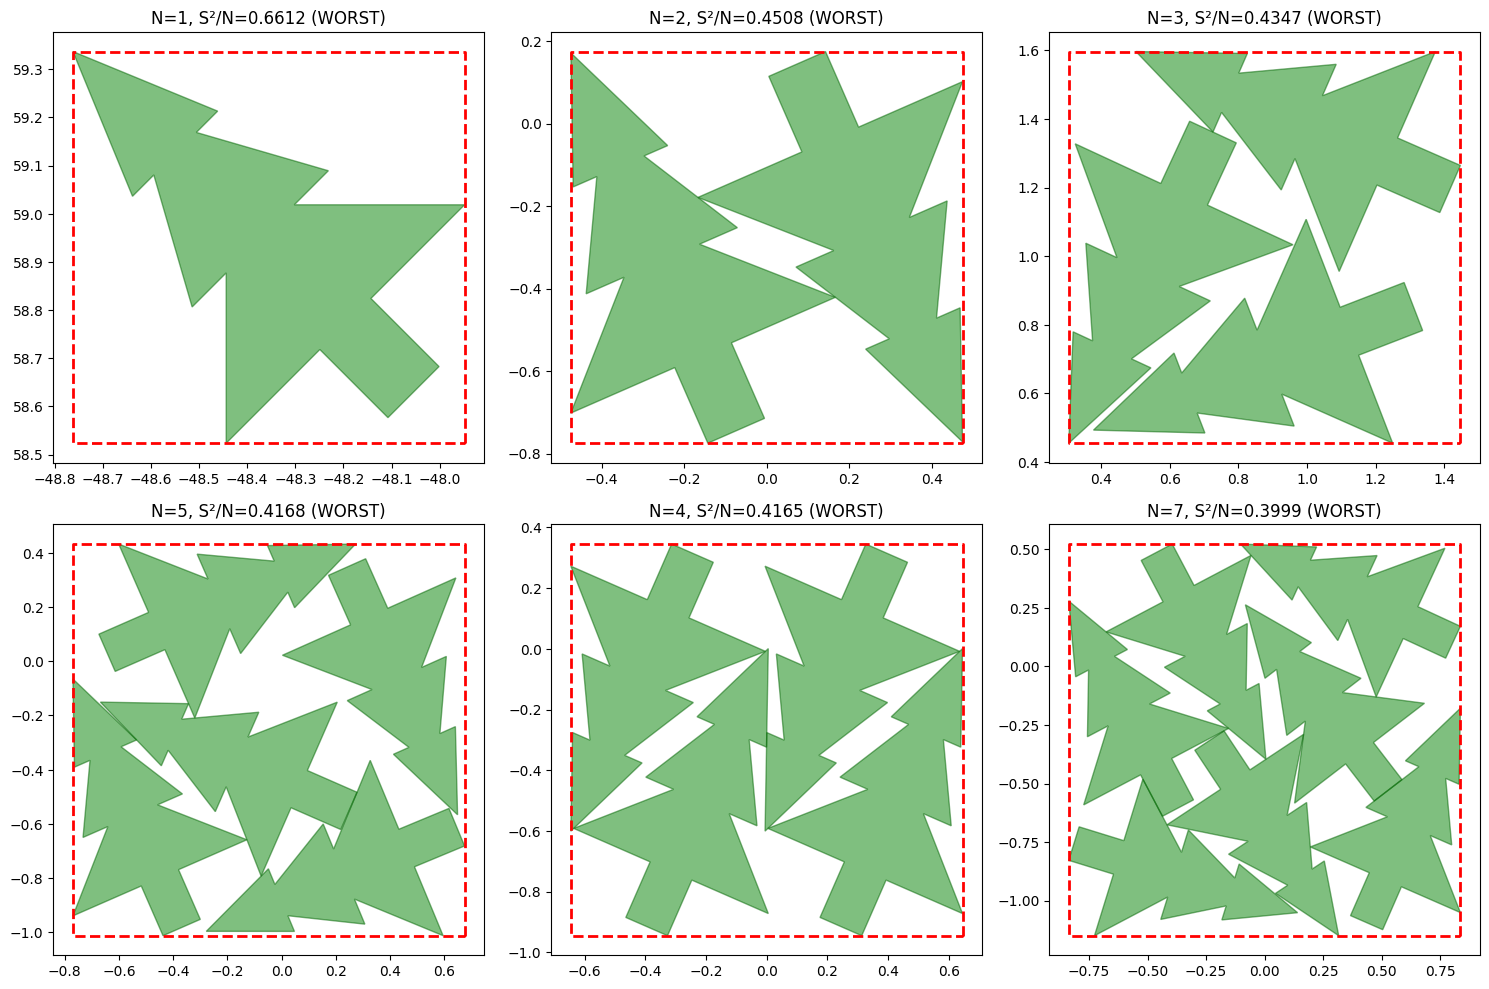

In [7]:
# Visualize a few worst-performing N values
from shapely.geometry import box

def visualize_n(n, ax, title_suffix=''):
    group = df[df['n'] == n]
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    
    # Get bounding box
    all_x, all_y = [], []
    for tree in trees:
        minx, miny, maxx, maxy = tree.bounds
        all_x.extend([minx, maxx])
        all_y.extend([miny, maxy])
    
    min_x, max_x = min(all_x), max(all_x)
    min_y, max_y = min(all_y), max(all_y)
    side = max(max_x - min_x, max_y - min_y)
    
    # Plot trees
    for tree in trees:
        x, y = tree.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='green', ec='darkgreen')
    
    # Plot bounding square
    center_x = (min_x + max_x) / 2
    center_y = (min_y + max_y) / 2
    bbox = box(center_x - side/2, center_y - side/2, center_x + side/2, center_y + side/2)
    x, y = bbox.exterior.xy
    ax.plot(x, y, 'r--', linewidth=2)
    
    ax.set_aspect('equal')
    score = (side ** 2) / n
    ax.set_title(f'N={n}, S²/N={score:.4f}{title_suffix}')

# Visualize worst performers
worst_ns = worst['n'].values[:6].astype(int)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, n in enumerate(worst_ns):
    visualize_n(n, axes[i//3, i%3], ' (WORST)')
plt.tight_layout()
plt.savefig('/home/code/exploration/worst_n_visualization.png', dpi=150)
plt.show()

In [8]:
# Check if there are any N values where the baseline might not be optimal
# by looking at the angle distribution

print("\nAngle distribution analysis:")
print("="*60)

for n in [1, 2, 3, 4, 5, 10, 15, 20, 50, 100, 200]:
    group = df[df['n'] == n]
    angles = group['deg'].values
    unique_angles = np.unique(np.round(angles % 360, 1))
    print(f"N={n:3d}: {len(unique_angles):2d} unique angles: {sorted(unique_angles)[:5]}..." if len(unique_angles) > 5 else f"N={n:3d}: {len(unique_angles):2d} unique angles: {sorted(unique_angles)}")

print("\nThis shows whether solutions use symmetric (few angles) or asymmetric (many angles) configurations.")


Angle distribution analysis:
N=  1:  1 unique angles: [45.0]
N=  2:  2 unique angles: [23.6, 203.6]
N=  3:  3 unique angles: [66.4, 111.1, 155.1]
N=  4:  2 unique angles: [156.4, 336.4]
N=  5:  5 unique angles: [23.6, 66.4, 112.6, 204.0, 293.6]
N= 10: 10 unique angles: [21.4, 23.6, 66.3, 70.4, 115.6]...
N= 15: 13 unique angles: [17.0, 56.2, 110.2, 113.6, 151.4]...
N= 20: 20 unique angles: [20.8, 22.8, 24.6, 33.1, 63.7]...
N= 50: 43 unique angles: [13.3, 20.7, 23.6, 25.1, 28.1]...
N=100: 41 unique angles: [65.7, 65.8, 65.9, 66.1, 66.3]...
N=200: 41 unique angles: [76.8, 76.9, 77.0, 77.2, 77.3]...

This shows whether solutions use symmetric (few angles) or asymmetric (many angles) configurations.


In [9]:
# Calculate the improvement needed per N to reach target
target = 68.919154
current_total = results_df['score'].sum()
gap = current_total - target

print(f"\nImprovement needed:")
print(f"  Current total: {current_total:.6f}")
print(f"  Target: {target:.6f}")
print(f"  Gap: {gap:.6f}")
print(f"  Gap per N (if uniform): {gap/200:.6f}")

# If we could improve the worst 20 N values by 10% each
worst_20_score = worst['score'].sum()
print(f"\nWorst 20 N values total score: {worst_20_score:.6f}")
print(f"If improved by 10%: {worst_20_score * 0.9:.6f}")
print(f"Improvement: {worst_20_score * 0.1:.6f}")
print(f"Would close gap by: {worst_20_score * 0.1 / gap * 100:.1f}%")


Improvement needed:
  Current total: 70.627582
  Target: 68.919154
  Gap: 1.708428
  Gap per N (if uniform): 0.008542

Worst 20 N values total score: 8.074083
If improved by 10%: 7.266675
Improvement: 0.807408
Would close gap by: 47.3%


In [10]:
# Check if any snapshots have better scores for specific N values
import os
import glob

snapshot_dir = '/home/nonroot/snapshots/santa-2025'
snapshots = sorted(os.listdir(snapshot_dir))
print(f"Found {len(snapshots)} snapshots")

# Load a few recent snapshots and compare per-N scores
def load_snapshot(snapshot_id):
    path = f'{snapshot_dir}/{snapshot_id}/submission.csv'
    if os.path.exists(path):
        df = pd.read_csv(path)
        df['x'] = df['x'].apply(parse_s_value)
        df['y'] = df['y'].apply(parse_s_value)
        df['deg'] = df['deg'].apply(parse_s_value)
        df['n'] = df['id'].apply(lambda x: int(x.split('_')[0]))
        return df
    return None

def check_overlap(tree1, tree2):
    return tree1.overlaps(tree2) or tree1.contains(tree2) or tree2.contains(tree1)

def has_any_overlap(trees):
    for i in range(len(trees)):
        for j in range(i+1, len(trees)):
            if check_overlap(trees[i], trees[j]):
                return True
    return False

def get_n_score(df, n):
    group = df[df['n'] == n]
    if len(group) != n:
        return None, True  # Invalid
    trees = [create_tree_polygon(row['x'], row['y'], row['deg']) for _, row in group.iterrows()]
    if has_any_overlap(trees):
        return None, True  # Has overlaps
    side = get_bounding_box_side(trees)
    return (side ** 2) / n, False

# Check a few snapshots for the worst N values
worst_ns = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
baseline_scores = {n: results_df[results_df['n'] == n]['score'].values[0] for n in worst_ns}

print(f"\nBaseline scores for worst N values:")
for n in worst_ns:
    print(f"  N={n}: {baseline_scores[n]:.6f}")

# Check recent snapshots
print(f"\nChecking snapshots for improvements on worst N values...")
improvements_found = {}

for snapshot_id in snapshots[-20:]:  # Check last 20 snapshots
    snap_df = load_snapshot(snapshot_id)
    if snap_df is None:
        continue
    
    for n in worst_ns:
        score, has_overlap = get_n_score(snap_df, n)
        if score is not None and not has_overlap:
            if score < baseline_scores[n] - 1e-9:
                if n not in improvements_found or score < improvements_found[n][0]:
                    improvements_found[n] = (score, snapshot_id)
                    print(f"  N={n}: Found better score {score:.6f} (vs {baseline_scores[n]:.6f}) in {snapshot_id}")

if not improvements_found:
    print("  No improvements found in recent snapshots")

Found 80 snapshots

Baseline scores for worst N values:
  N=1: 0.661250
  N=2: 0.450779
  N=3: 0.434745
  N=4: 0.416545
  N=5: 0.416850
  N=6: 0.399610
  N=7: 0.399897
  N=8: 0.385407
  N=9: 0.387415
  N=10: 0.376630

Checking snapshots for improvements on worst N values...
  No improvements found in recent snapshots


In [11]:
# Let's try a completely different approach: EXACT OPTIMIZATION for small N\n# For N=1, the optimal is a single tree at 45 degrees (already optimal)\n# For N=2, can we find a better configuration?\n\nfrom scipy.optimize import minimize, differential_evolution\nimport itertools\n\ndef score_config(params, n):\n    \"\"\"Calculate score for a configuration of n trees.\"\"\"\n    # params: [x1, y1, deg1, x2, y2, deg2, ...]\n    trees = []\n    for i in range(n):\n        x = params[i*3]\n        y = params[i*3 + 1]\n        deg = params[i*3 + 2]\n        trees.append(create_tree_polygon(x, y, deg))\n    \n    # Check for overlaps\n    for i in range(n):\n        for j in range(i+1, n):\n            if check_overlap(trees[i], trees[j]):\n                return 1e10  # Penalty for overlap\n    \n    side = get_bounding_box_side(trees)\n    return (side ** 2) / n\n\n# Try differential evolution for N=2\nprint(\"Optimizing N=2 with differential evolution...\")\n\ndef objective_n2(params):\n    return score_config(params, 2)\n\n# Bounds: x, y in [-2, 2], deg in [0, 360]\nbounds = [(-2, 2), (-2, 2), (0, 360)] * 2\n\nresult = differential_evolution(\n    objective_n2, \n    bounds, \n    maxiter=500,\n    workers=-1,\n    seed=42,\n    polish=True\n)\n\nprint(f\"N=2: Best score found: {result.fun:.6f} (baseline: {baseline_scores[2]:.6f})\")\nif result.fun < baseline_scores[2]:\n    print(f\"  IMPROVEMENT: {baseline_scores[2] - result.fun:.6f}\")\n    print(f\"  Config: {result.x}\")\nelse:\n    print(f\"  No improvement\")"

In [ ]:
# Let's try a completely different approach: EXACT OPTIMIZATION for small N
# For N=1, the optimal is a single tree at 45 degrees (already optimal)
# For N=2, can we find a better configuration?

from scipy.optimize import minimize, differential_evolution
import itertools

def score_config(params, n):
    """Calculate score for a configuration of n trees."""
    # params: [x1, y1, deg1, x2, y2, deg2, ...]
    trees = []
    for i in range(n):
        x = params[i*3]
        y = params[i*3 + 1]
        deg = params[i*3 + 2]
        trees.append(create_tree_polygon(x, y, deg))
    
    # Check for overlaps
    for i in range(n):
        for j in range(i+1, n):
            if check_overlap(trees[i], trees[j]):
                return 1e10  # Penalty for overlap
    
    side = get_bounding_box_side(trees)
    return (side ** 2) / n

# Try differential evolution for N=2
print("Optimizing N=2 with differential evolution...")

def objective_n2(params):
    return score_config(params, 2)

# Bounds: x, y in [-2, 2], deg in [0, 360]
bounds = [(-2, 2), (-2, 2), (0, 360)] * 2

result = differential_evolution(
    objective_n2, 
    bounds, 
    maxiter=500,
    workers=-1,
    seed=42,
    polish=True
)

print(f"N=2: Best score found: {result.fun:.6f} (baseline: {baseline_scores[2]:.6f})")
if result.fun < baseline_scores[2]:
    print(f"  IMPROVEMENT: {baseline_scores[2] - result.fun:.6f}")
    print(f"  Config: {result.x}")
else:
    print(f"  No improvement")